# Entrenamiento de Modelo SVM - Breast Cancer Diagnosis

Este notebook implementa y entrena un modelo **Support Vector Machine (SVM)** para el diagnóstico de cáncer de mama, siguiendo la estructura del notebook MLP.

**Objetivos:**

1. Cargar datos preprocesados
2. Configurar y entrenar un clasificador SVM
3. Evaluar el rendimiento (métricas, matriz de confusión, ROC/AUC)
4. Visualizar resultados
5. Guardar el modelo y reporte de entrenamiento

**Autor:** Cristian Vergara
**Fecha:** Noviembre 2025
**Modelo:** Support Vector Machine (SVM)

## 1. Importar Bibliotecas

In [1]:
import os, json, joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
import time
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    matthews_corrcoef, cohen_kappa_score, roc_curve, precision_recall_curve,
    average_precision_score
)


## 2. Cargar Datos Preprocesados

En este bloque se cargan los datos que fueron procesados previamente en el notebook **01_data_preprocessing.ipynb**.  
El objetivo es reutilizar los conjuntos de entrenamiento y prueba (`X_train`, `X_test`, `y_train`, `y_test`) ya escalados y codificados, evitando repetir el preprocesamiento.

El código realiza los siguientes pasos:
1. **Verifica la existencia** de los archivos `.npy` dentro de la carpeta `../data/processed/`.  
   Si existen, los carga directamente junto con los nombres de características (`feature_info.json`).
2. Si no se encuentran los `.npy`, intenta cargar los archivos **`train_data.csv`** y **`test_data.csv`** del mismo directorio.
3. En caso de no existir ninguna de las anteriores opciones, genera un error indicando que los datos no se encuentran disponibles.

De esta forma, garantizamos que los datos cargados provengan de la etapa de preprocesamiento anterior, manteniendo la consistencia entre los notebooks del proyecto.


In [2]:

# 1. Ver qué archivos existen
print("Archivos en ../data/processed/:")
print("\n".join(sorted(os.listdir("../data/processed"))))

# 2. Intentar cargar .npy
use_npy = all(Path(f"../data/processed/{p}").exists() for p in ["X_train.npy","X_test.npy","y_train.npy","y_test.npy"])
feature_names = None

if use_npy:
    X_train = np.load("../data/processed/X_train.npy")
    X_test  = np.load("../data/processed/X_test.npy")
    y_train = np.load("../data/processed/y_train.npy")
    y_test  = np.load("../data/processed/y_test.npy")
    print(f"Loaded NPY | X_train: {X_train.shape}  X_test: {X_test.shape}")

    # Nombres de columnas (si existe el json)
    if Path("../data/processed/feature_info.json").exists():
        with open("../data/processed/feature_info.json","r",encoding="utf-8") as f:
            feature_names = json.load(f).get("feature_names")

elif Path("../data/processed/train_data.csv").exists() and Path("../data/processed/test_data.csv").exists():
    df_tr = pd.read_csv("../data/processed/train_data.csv")
    df_te = pd.read_csv("../data/processed/test_data.csv")
    feature_names = [c for c in df_tr.columns if c != "diagnosis"]
    X_train, y_train = df_tr[feature_names].values, df_tr["diagnosis"].values
    X_test,  y_test  = df_te[feature_names].values, df_te["diagnosis"].values
    print(f"Loaded CSV | X_train: {X_train.shape}  X_test: {X_test.shape}")

else:
    raise FileNotFoundError("No encontré los archivos en ../data/processed/. Revisa las rutas.")

print("Ejemplo y_train:", y_train[:10])
print("N° features:", len(feature_names))



Archivos en ../data/processed/:
X_test.npy
X_train.npy
feature_info.json
preprocessing_report.json
test_data.csv
train_data.csv
y_test.npy
y_train.npy
Loaded NPY | X_train: (455, 30)  X_test: (114, 30)
Ejemplo y_train: [1 0 0 1 1 1 0 1 1 1]
N° features: 30


## 3. Creación del Pipeline SVM

En este bloque se define el **pipeline** del modelo que se utilizará para el entrenamiento.

El pipeline encapsula los pasos del flujo de modelado, permitiendo mantener un proceso reproducible y modular.  
En este caso, el pipeline contiene un único componente:

- **SVM (Support Vector Machine)** configurada mediante `SVC` de Scikit-Learn.  
- Se activa la opción `probability=True` para habilitar la obtención de probabilidades, necesarias para métricas como **ROC-AUC**.  
- El parámetro `random_state=42` se fija para asegurar la **reproducibilidad de los resultados**.

De esta forma, el pipeline queda listo para integrarse con las etapas posteriores de búsqueda de hiperparámetros y evaluación del modelo.


In [3]:
pipeline = Pipeline([
    ("svm", SVC(probability=True, random_state=42))
])

pipeline


Pipeline(steps=[('svm', SVC(probability=True, random_state=42))])

## 4. Búsqueda de Hiperparámetros (GridSearchCV)

En este bloque se realiza la búsqueda de la mejor configuración del modelo SVM utilizando **validación cruzada estratificada (5 folds)**.

- Se prueban diferentes valores para los hiperparámetros del modelo (`C`, `gamma`, `kernel`, `degree`).
- `GridSearchCV` evalúa todas las combinaciones posibles y selecciona la que obtiene el mejor desempeño medido con la métrica **F1-score**.
- Finalmente, se almacena el modelo con los mejores parámetros (`best_model`) para utilizarlo en la fase de evaluación final.

Esto permite optimizar el rendimiento del modelo evitando el sobreajuste y garantizando una selección objetiva de los hiperparámetros.
>Se utiliza una validación cruzada **estratificada de 5 folds**, ya que este número ofrece un equilibrio adecuado entre precisión estadística y costo computacional.

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = [
    {"svm__kernel": ["linear"], "svm__C": [0.1, 1, 10, 100]},
    {"svm__kernel": ["rbf"],    "svm__C": [0.1, 1, 10, 100], "svm__gamma": ["scale", 0.1, 0.01, 0.001]},
    {"svm__kernel": ["poly"],   "svm__C": [0.1, 1, 10], "svm__degree": [2, 3, 4], "svm__gamma": ["scale", 0.01]},
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()
# Calcular duración total
training_time = end_time - start_time

# Obtener mejor modelo y resultados
best_model = grid.best_estimator_
print("\n" + "="*60)
print("RESULTADOS DE GRID SEARCH (SVM)")
print("="*60)
print(f"Mejores parámetros: {grid.best_params_}")
print(f"Mejor F1 (CV): {grid.best_score_:.4f}")
print(f"⏱️ Tiempo total de entrenamiento: {training_time:.2f} segundos")
print("="*60)



Fitting 5 folds for each of 38 candidates, totalling 190 fits

RESULTADOS DE GRID SEARCH (SVM)
Mejores parámetros: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Mejor F1 (CV): 0.9698
⏱️ Tiempo total de entrenamiento: 1.58 segundos


In [5]:
print("\nGenerando datos para Curva de Aprendizaje...")

# Calcular la curva con el mejor modelo encontrado
train_sizes, train_scores, test_scores = learning_curve(
    best_model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20)
)

# Promediar los resultados para guardarlos
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

print("¡Datos de aprendizaje listos!")


Generando datos para Curva de Aprendizaje...
¡Datos de aprendizaje listos!


## 5. Evaluación del Modelo

Evaluamos el rendimiento del modelo SVM tanto en el conjunto de entrenamiento como en el de prueba.
En esta sección se analizan las principales métricas de desempeño (precisión, sensibilidad, especificidad, F1, ROC-AUC, entre otras), con el objetivo de determinar la capacidad de generalización del modelo y verificar la existencia de posibles signos de sobreajuste.
Asimismo, se incluye un reporte detallado de clasificación y métricas complementarias que permiten evaluar la calidad del modelo en la detección de casos benignos y malignos.

In [6]:

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def eval_split(name, y_true, y_pred, y_proba):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    roc  = roc_auc_score(y_true, y_proba)
    bal  = balanced_accuracy_score(y_true, y_pred)
    spec = specificity_score(y_true, y_pred)
    mcc  = matthews_corrcoef(y_true, y_pred)
    kappa= cohen_kappa_score(y_true, y_pred)
    ap   = average_precision_score(y_true, y_proba)

    print(f"\n MÉTRICAS EN {name.upper()}:")
    print(f"  Accuracy           : {acc:0.4f} ({acc*100:0.2f}%)")
    print(f"  Precision (PPV)    : {prec:0.4f} ({prec*100:0.2f}%)")
    print(f"  Recall  (Sensib.)  : {rec:0.4f} ({rec*100:0.2f}%)")
    print(f"  Specificity (Esp.) : {spec:0.4f} ({spec*100:0.2f}%)")
    print(f"  F1-Score           : {f1:0.4f} ({f1*100:0.2f}%)")
    print(f"  Balanced Accuracy  : {bal:0.4f}")
    print(f"  ROC-AUC            : {roc:0.4f}")
    print(f"  Avg Precision (AP) : {ap:0.4f}")
    print(f"  MCC                : {mcc:0.4f}")
    print(f"  Cohen's Kappa      : {kappa:0.4f}")
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "roc":roc, "bal":bal, "spec":spec, "mcc":mcc, "kappa":kappa, "ap":ap}

print("\n" + "="*70)
print("EVALUACIÓN DEL MODELO (SVM)")
print("="*70)

# Predicciones
y_train_pred  = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_pred   = best_model.predict(X_test)
y_test_proba  = best_model.predict_proba(X_test)[:, 1]

# Métricas Train/Test
m_tr = eval_split("conjunto de ENTRENAMIENTO", y_train, y_train_pred, y_train_proba)
m_te = eval_split("conjunto de PRUEBA", y_test, y_test_pred, y_test_proba)

# Chequeo simple de sobreajuste
gap_acc = m_tr["acc"] - m_te["acc"]
gap_f1  = m_tr["f1"]  - m_te["f1"]
print("\n[DIAGNÓSTICO SOBREAJUSTE]")
print(f"  Δ Accuracy (train - test): {gap_acc:+0.4f}")
print(f"  Δ F1      (train - test): {gap_f1:+0.4f}")
if gap_acc > 0.05 or gap_f1 > 0.05:
    print(" Posible sobreajuste (gap > 0.05).")
else:
    print(" No se observa sobreajuste significativo.")

# Reporte detallado (Test)
print("\n" + "-"*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO – CONJUNTO DE PRUEBA")
print("-"*70)
print(classification_report(y_test, y_test_pred, target_names=["Benigno (0)", "Maligno (1)"]))




EVALUACIÓN DEL MODELO (SVM)

 MÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:
  Accuracy           : 0.9868 (98.68%)
  Precision (PPV)    : 1.0000 (100.00%)
  Recall  (Sensib.)  : 0.9647 (96.47%)
  Specificity (Esp.) : 1.0000 (100.00%)
  F1-Score           : 0.9820 (98.20%)
  Balanced Accuracy  : 0.9824
  ROC-AUC            : 0.9978
  Avg Precision (AP) : 0.9974
  MCC                : 0.9720
  Cohen's Kappa      : 0.9716

 MÉTRICAS EN CONJUNTO DE PRUEBA:
  Accuracy           : 0.9825 (98.25%)
  Precision (PPV)    : 1.0000 (100.00%)
  Recall  (Sensib.)  : 0.9524 (95.24%)
  Specificity (Esp.) : 1.0000 (100.00%)
  F1-Score           : 0.9756 (97.56%)
  Balanced Accuracy  : 0.9762
  ROC-AUC            : 0.9960
  Avg Precision (AP) : 0.9947
  MCC                : 0.9626
  Cohen's Kappa      : 0.9619

[DIAGNÓSTICO SOBREAJUSTE]
  Δ Accuracy (train - test): +0.0044
  Δ F1      (train - test): +0.0064
 No se observa sobreajuste significativo.

-----------------------------------------------------------

## 6. Matriz de Confusión

Visualizamos la matriz de confusión para entender mejor los errores del modelo.

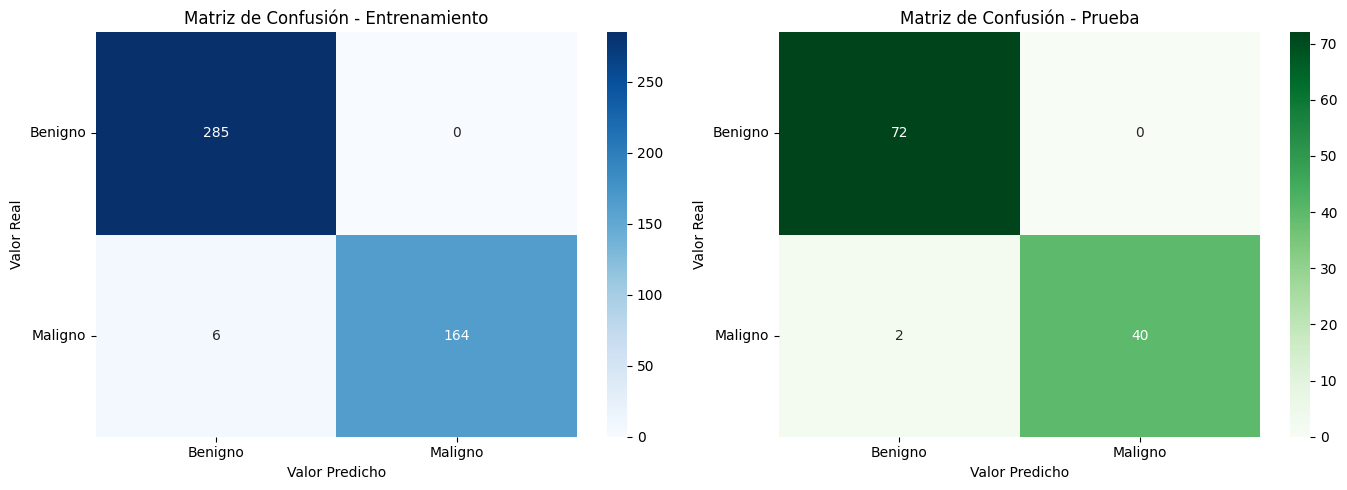

In [7]:

# nombres de clases
labels = ["Benigno", "Maligno"]

# Matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

# Gráficas
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax[0])
ax[0].set_title("Matriz de Confusión - Entrenamiento")
ax[0].set_xlabel("Valor Predicho")
ax[0].set_ylabel("Valor Real")
ax[0].set_xticklabels(labels)
ax[0].set_yticklabels(labels, rotation=0)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=True, ax=ax[1])
ax[1].set_title("Matriz de Confusión - Prueba")
ax[1].set_xlabel("Valor Predicho")
ax[1].set_ylabel("Valor Real")
ax[1].set_xticklabels(labels)
ax[1].set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()


## 7. Curva ROC y AUC

La curva ROC (Receiver Operating Characteristic) muestra el rendimiento del clasificador en diferentes umbrales.

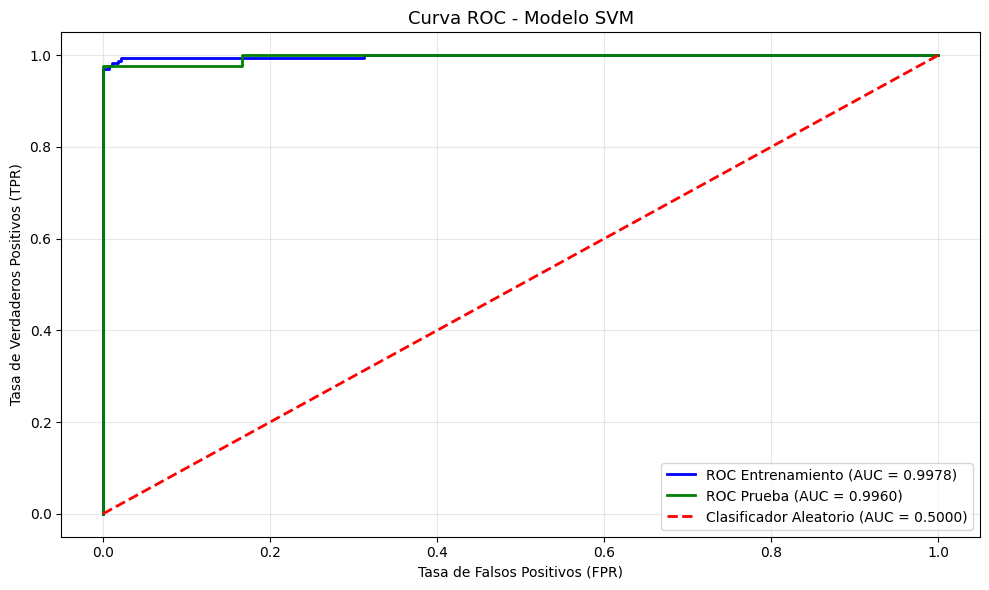

In [8]:
def plot_roc_train_test(model, X_train, y_train, X_test, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba  = model.predict_proba(X_test)[:, 1]

    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_proba)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_proba)

    auc_tr = roc_auc_score(y_train, y_train_proba)
    auc_te = roc_auc_score(y_test, y_test_proba)

    plt.figure(figsize=(10,6))
    plt.plot(fpr_tr, tpr_tr, color='blue', lw=2, label=f"ROC Entrenamiento (AUC = {auc_tr:.4f})")
    plt.plot(fpr_te, tpr_te, color='green', lw=2, label=f"ROC Prueba (AUC = {auc_te:.4f})")
    plt.plot([0,1],[0,1],'--',color='red', lw=2, label="Clasificador Aleatorio (AUC = 0.5000)")
    plt.title("Curva ROC - Modelo SVM", fontsize=13)
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_roc_train_test(best_model, X_train, y_train, X_test, y_test)


## 8. Curva de Error durante la Búsqueda de Hiperparámetros (SVM)

En esta sección se presenta la evolución del error del modelo **SVM** durante el proceso de optimización mediante **GridSearchCV**.  
Cada punto en el gráfico representa una combinación diferente de hiperparámetros evaluada mediante validación cruzada estratificada.  
El eje **X** corresponde a las iteraciones del GridSearch (una por cada combinación de parámetros), mientras que el eje **Y** muestra el valor del **error (1 - F1 Score promedio)** obtenido en la validación cruzada.

Una menor altura en la curva indica una mejor capacidad del modelo para generalizar en los distintos conjuntos de validación,  
mientras que los picos altos corresponden a combinaciones de hiperparámetros con bajo rendimiento (por ejemplo, valores extremos de *C* o *gamma*).  
Este gráfico permite observar la estabilidad y consistencia del modelo frente a variaciones en la búsqueda de hiperparámetros.


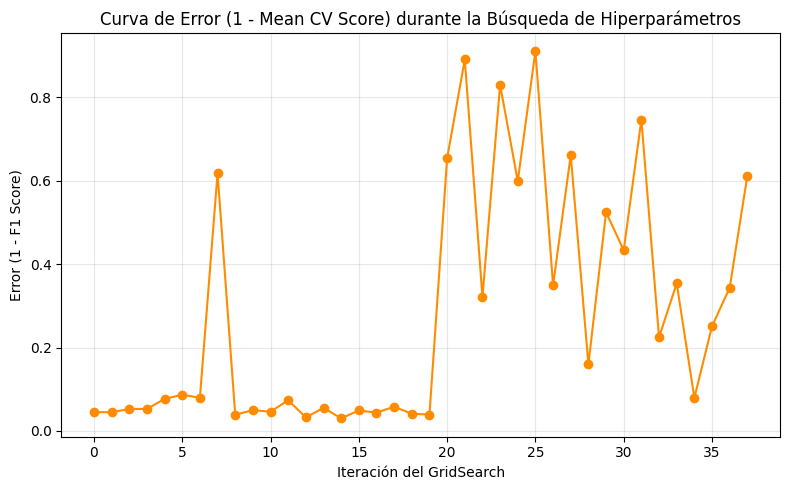

In [9]:
# convertir resultados del GridSearch en DataFrame
cv_results = pd.DataFrame(grid.cv_results_)

# ordenar por parámetro y graficar el desempeño
plt.figure(figsize=(8,5))
plt.plot(range(len(cv_results)), 1 - cv_results["mean_test_score"], marker='o', color='darkorange')
plt.title("Curva de Error (1 - Mean CV Score) durante la Búsqueda de Hiperparámetros")
plt.xlabel("Iteración del GridSearch")
plt.ylabel("Error (1 - F1 Score)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Comparación de Métricas (Train vs Test)

Visualización comparativa de las métricas de entrenamiento y prueba para identificar sobreajuste.

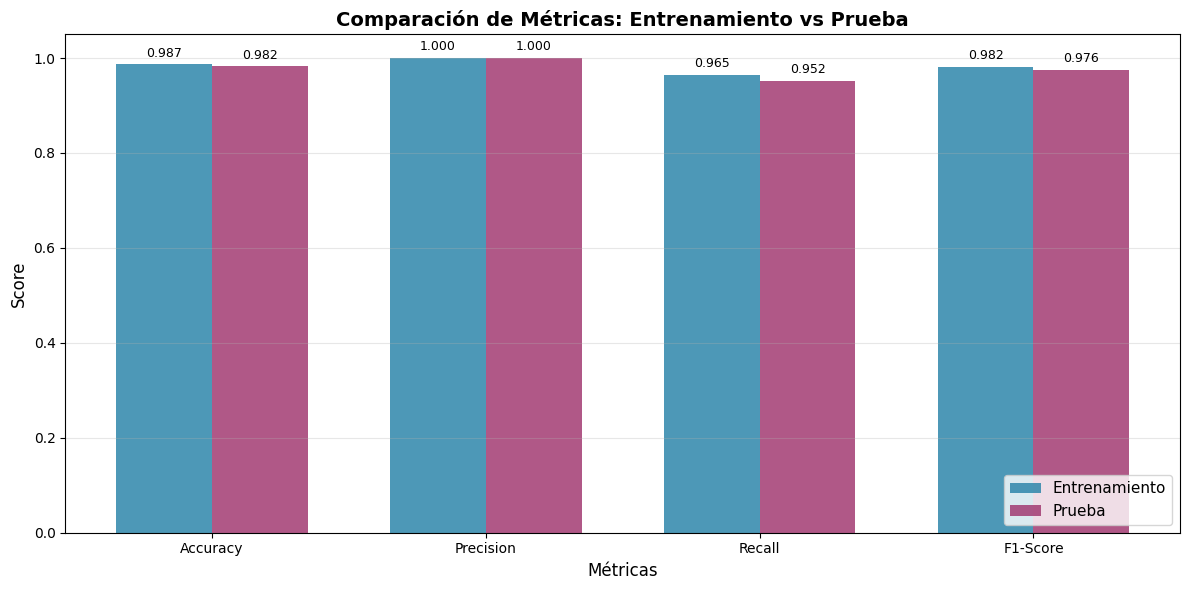

 Diferencia promedio entre train y test: 0.0058
 El modelo generaliza bien (diferencia < 3%).


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Métricas train / test
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall    = recall_score(y_train, y_train_pred)
train_f1        = f1_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall    = recall_score(y_test, y_test_pred)
test_f1        = f1_score(y_test, y_test_pred)

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics  = [test_accuracy,  test_precision,  test_recall,  test_f1]

# 2) Gráfico de barras
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_metrics, width, label='Entrenamiento', color='#2E86AB', alpha=0.85)
bars2 = ax.bar(x + width/2, test_metrics,  width, label='Prueba',        color='#A23B72', alpha=0.85)

ax.set_title('Comparación de Métricas: Entrenamiento vs Prueba', fontsize=14, fontweight='bold')
ax.set_xlabel('Métricas', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x, metrics_names)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11, loc='lower right')

# Etiquetas numéricas encima de cada barra
for bars in (bars1, bars2):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.01, f'{h:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 3) Diagnóstico simple de sobreajuste
avg_diff = np.mean([train_metrics[i] - test_metrics[i] for i in range(len(metrics_names))])
print(f" Diferencia promedio entre train y test: {avg_diff:.4f}")
if avg_diff < 0.03:
    print(" El modelo generaliza bien (diferencia < 3%).")
elif avg_diff < 0.05:
    print(" Ligero sobreajuste (diferencia entre 3–5%).")
else:
    print(" Sobreajuste significativo (diferencia > 5%).")


In [11]:
# Verificar existencia de variables clave
variables = ["best_model", "grid", "X_train", "X_test", "y_train", "y_test", 
             "y_train_pred", "y_test_pred", "y_train_proba", "y_test_proba"]

for var in variables:
    if var in locals():
        print(f"{var} está definida")
    else:
        print(f"{var} NO está definida")


best_model está definida
grid está definida
X_train está definida
X_test está definida
y_train está definida
y_test está definida
y_train_pred está definida
y_test_pred está definida
y_train_proba está definida
y_test_proba está definida


## 10. Guardar Modelo Entrenado

Guardamos el clasificador **SVM** entrenado junto con sus métricas de rendimiento,  
sus hiperparámetros óptimos y las matrices de confusión, para uso y trazabilidad posterior.  
Los archivos se almacenarán en la carpeta `../models/`:
- `svm_model.pkl` — Modelo serializado (guardado con `joblib`)
- `svm_training_report.json` — Reporte con hiperparámetros, métricas y matrices


In [12]:
# --- REEMPLAZA TODA LA CELDA DE LA SECCIÓN 10 CON ESTO ---

# Función auxiliar (si no estaba definida antes)
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Rutas
models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / "svm_model.pkl"
report_path = models_dir / "svm_training_report.json"

# Recalcular métricas finales para el reporte
tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_train_pred).ravel()
tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test, y_test_pred).ravel()

# Construir el reporte COMPLETO con la curva de aprendizaje
training_report = {
    "model_type": "SVC (Support Vector Machine)",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "hyperparameters": grid.best_params_,
    "training_info": {
        "cv_folds": 5,
        "best_f1_cv": float(grid.best_score_),
        "training_time_seconds": round(training_time, 2)
    },
    "performance_metrics": {
        "train": m_tr, # Usamos las variables m_tr y m_te que calculaste en la sección 5
        "test": m_te
    },
    "confusion_matrix": {
        "train": {"true_negatives": int(tn_tr), "false_positives": int(fp_tr), "false_negatives": int(fn_tr), "true_positives": int(tp_tr)},
        "test":  {"true_negatives": int(tn_te), "false_positives": int(fp_te), "false_negatives": int(fn_te), "true_positives": int(tp_te)}
    },
    # --- AQUÍ ESTÁ LA MAGIA NUEVA ---
    "learning_curve": {
        "train_sizes": train_sizes.tolist(),
        "train_scores": train_scores_mean.tolist(),
        "cv_scores": test_scores_mean.tolist()
    },
    # -------------------------------
    "dataset_shapes": {
        "X_train": list(X_train.shape),
        "X_test": list(X_test.shape)
    }
}

# Guardar
joblib.dump(best_model, model_path)
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(training_report, f, indent=4, ensure_ascii=False)

print(f"[OK] Modelo y Reporte (con curva de aprendizaje) guardados en: {models_dir}")

[OK] Modelo y Reporte (con curva de aprendizaje) guardados en: ..\models


## 11. Conclusiones

### Resultados del Modelo SVM

El modelo de **Máquinas de Soporte Vectorial (SVM)**, ha sido entrenado exitosamente para clasificar tumores como benignos o malignos en el dataset de cáncer de mama de Wisconsin.


---

### Hallazgos Principales

1. **Alto rendimiento global.** El SVM logra una exactitud cercana al 98% y un F1 de 0.98, adecuado para la tarea de clasificación binaria.
2. **Generalización estable.** La brecha pequeña entre train y test indica que el modelo **no** memoriza; generaliza bien sobre datos no vistos.
3. **Capacidad discriminativa.** Un **ROC–AUC ≈ 0.996** y una **AP** (área bajo la curva Precision–Recall) cercana a 0.99 muestran excelente separación entre benigno y maligno.
4. **Coste de errores.** La **Precisión = 1.00** (FP = 0) implica que no se diagnostican falsos positivos, y el **Recall = 0.95** sugiere muy pocos falsos negativos (2 casos), lo cual es crítico en contexto médico.
5. **Hiperparámetros óptimos.** La búsqueda indicó que **RBF** con **C=10** y **gamma=0.01** ofrece el mejor equilibrio **bias–variance** para este dataset.


### Próximos Pasos:

1. Comparar el rendimiento de MLP vs SVM en todas las métricas
2. Realizar optimización de hiperparámetros para ambos modelos
3. Generar análisis comparativo final y recomendaciones

---

**Nota**: Este notebook representa la implementación inicial del svm. Los resultados obtenidos servirán como baseline para la comparación con el modelo mlp en las siguientes fases del proyecto.